<a href="https://colab.research.google.com/github/Neo-glitch/kaggle_competitions/blob/main/digit_recognizer_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
                            f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from IPython.display import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, \
                Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
train_data = pd.read_csv("../input/digit-recognizer/train.csv")

test_data = pd.read_csv("../input/digit-recognizer/test.csv")

submission_data = pd.read_csv("../input/digit-recognizer/sample_submission.csv")

train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA

In [ ]:
x = train_data.drop(["label"], axis = 1)

y = train_data["label"]

x.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
x.shape, y.shape

((42000, 784), (42000,))

In [ ]:
# from here, seen that pixel values are int rather than float
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 251.2 MB


In [ ]:
print("classes are: ", np.unique(y.to_numpy()))
print("num of classes are: ", len(np.unique(y.to_numpy())))

classes are:  [0 1 2 3 4 5 6 7 8 9]
num of classes are:  10


In [ ]:
# range of pixels is 0 - 255 which will be scaled t be within 0 and 1
x.to_numpy().min(), x.to_numpy().max()

(0, 255)

(-0.5, 27.5, 27.5, -0.5)

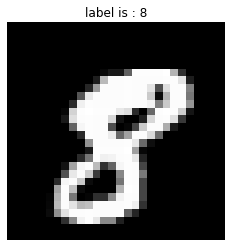

In [ ]:
# plot single X and Y label
idx = 10
img = x.to_numpy()[idx].reshape(28, 28, 1)
num = y[idx]

img = array_to_img(img)

plt.imshow(img, cmap = "gray")
plt.title(f"label is : {num}")
plt.axis("off")

<AxesSubplot:xlabel='label', ylabel='count'>

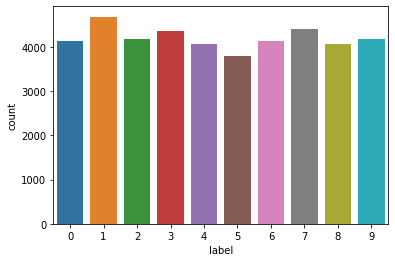

In [ ]:
# seen that majority of data belongs that class 1
sns.countplot(x = y)

In [ ]:
# to check for rows with nan values
# we appear to be good
x[x.isnull().any(axis = 1)]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783


## Preprocess data

In [ ]:
# reshape x to be 28 * 28 and of type float
images = x.to_numpy().reshape(-1, 28, 28).astype("float64")
labels = y.to_numpy()

In [ ]:
images.shape, labels.shape

((42000, 28, 28), (42000,))

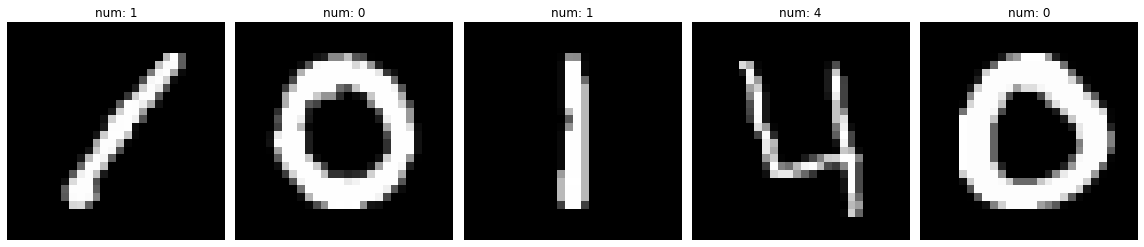

In [ ]:
# helper to viz images and labels
def plot_cat(images, labels):
  fig, axes = plt.subplots(1, 5, figsize = (16,15))
  axes = axes.ravel()

  for k in range(5):
    img = images[k]
    img = np.expand_dims(img, axis = -1)
    img = array_to_img(img)
    ax = axes[k]

    ax.imshow(img, cmap = "gray")
    ax.set_title(f"num: {labels[k]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_cat(images, labels)

In [ ]:
# split data into train and eval
# x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size = 0.25, shuffle = True, random_state = 40)

n_splits = 1
split = StratifiedShuffleSplit(n_splits = n_splits, test_size = 0.1, random_state = 40)

for train_idx, val_idx in split.split(images, labels):
    x_train, x_val = images[train_idx], images[val_idx] 
    y_train, y_val = labels[train_idx], labels[val_idx]


len(x_train), len(x_val)

(37800, 4200)

<AxesSubplot:title={'center':'Validation dataset label distribution'}, ylabel='count'>

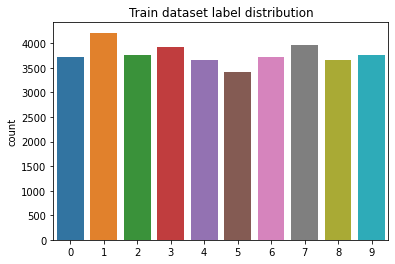

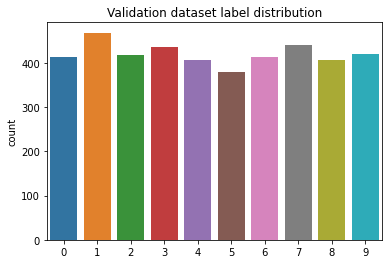

In [ ]:
plt.title("Train dataset label distribution")
sns.countplot(x = y_train)

plt.figure()

plt.title("Validation dataset label distribution")
sns.countplot(x = y_val)

# Excellent same distro of y in train data is same as that of validation data

In [ ]:
# helper to get train and val generators
def train_val_generators(x_train, y_train, x_val, y_val):

  # adds 1 to x_train to denote the color channels which is 1 i.e gray scale image
  x_train = x_train[..., np.newaxis]
  x_val = x_val[..., np.newaxis]

  train_datagen = ImageDataGenerator(
      rescale = 1/255.,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      zoom_range = 0.1,
      rotation_range = 10,
      shear_range = 0.1,
      fill_mode = "nearest"
  )

  val_datagen = ImageDataGenerator(rescale = 1/255.)

  train_generator = train_datagen.flow(x = x_train,
                                       y = y_train,
                                       batch_size = 64)
  
  val_generator = val_datagen.flow(x = x_val, y = y_val, batch_size = 32)

  return train_generator, val_generator

In [ ]:
train_generator, val_generator = train_val_generators(x_train, y_train, x_val, y_val)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {val_generator.x.shape}")
print(f"Labels of validation generator have shape: {val_generator.y.shape}")

Images of training generator have shape: (37800, 28, 28, 1)
Labels of training generator have shape: (37800,)
Images of validation generator have shape: (4200, 28, 28, 1)
Labels of validation generator have shape: (4200,)


### Create Model and Train

In [ ]:
# build the model

def create_model():
    model = keras.models.Sequential([
      
        Input(shape  = [28, 28, 1]),
          # Conv 1 block
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        BatchNormalization(axis = -1),
      
        # Conv 2 block
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        BatchNormalization(axis = -1),
      
        # Conv 3 block
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(2, 2),
        BatchNormalization(axis = -1),
      
        Flatten(),
        
        Dense(512, activation ="relu"),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(128, activation ="relu"),
        BatchNormalization(),
#         Dropout(0.1),
        
        Dense(10, activation="softmax")
    ])

    
    optimizer = Adam()

    model.compile(optimizer = optimizer,
                loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"],
                steps_per_execution = 1  # to denote number of steps before executing callbacks
                 )

    return model

In [ ]:
model = create_model()

model.summary()

2022-10-08 18:29:57.726180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 18:29:57.817195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 18:29:57.818021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 18:29:57.819824: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [ ]:
# custom learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
learning_rate_scheduler = LearningRateScheduler(schedule=scheduler)
chkpt = ModelCheckpoint(filepath = "best_model_trained", save_best_only = True, 
                        save_weights_only=True)
    
# determines how muchb do reduce our learning rate, when it appears to not be learning
# i.e loss is static meaning we are in a plateau
reduce_lr_on_plateau = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 6, verbose=3)

history = model.fit(train_generator, 
                    validation_data = val_generator,
                    epochs = 45,
                    callbacks = [learning_rate_scheduler, chkpt, reduce_lr_on_plateau]
                   )

Epoch 1/45


2022-10-08 18:30:00.509156: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-08 18:30:02.399744: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


591/591 [==============================] - 23s 25ms/step - loss: 0.1760 - accuracy: 0.9452 - val_loss: 0.0640 - val_accuracy: 0.9810
Epoch 2/45
591/591 [==============================] - 13s 22ms/step - loss: 0.0699 - accuracy: 0.9784 - val_loss: 0.0502 - val_accuracy: 0.9840
Epoch 3/45
591/591 [==============================] - 14s 23ms/step - loss: 0.0560 - accuracy: 0.9823 - val_loss: 0.0446 - val_accuracy: 0.9860
Epoch 4/45
591/591 [==============================] - 13s 22ms/step - loss: 0.0501 - accuracy: 0.9837 - val_loss: 0.0441 - val_accuracy: 0.9860
Epoch 5/45
591/591 [==============================] - 13s 23ms/step - loss: 0.0424 - accuracy: 0.9868 - val_loss: 0.0616 - val_accuracy: 0.9798
Epoch 6/45
591/591 [==============================] - 13s 22ms/step - loss: 0.0366 - accuracy: 0.9885 - val_loss: 0.0961 - val_accuracy: 0.9702
Epoch 7/45
591/591 [==============================] - 14s 24ms/step - loss: 0.0376 - accuracy: 0.9881 - val_loss: 0.0217 - val_accuracy: 0.9938
Epo

In [ ]:
# New best baseline =  0.9955238103866577

# bestto use f1_score and recall to rate this below

model.evaluate(val_generator)

132/132 [==============================] - 1s 6ms/step - loss: 0.0135 - accuracy: 0.9964


[0.013461632654070854, 0.9964285492897034]

#### Eval Model

In [ ]:
sample = x_val[20: 30] / 255.

predictions = np.argmax(model.predict(sample.reshape(-1, 28, 28, 1)), axis = 1)

In [ ]:
y_val[20:30]

array([8, 9, 0, 9, 9, 2, 8, 9, 4, 4])

In [ ]:
predictions

array([8, 9, 0, 9, 9, 2, 8, 9, 4, 4])

In [ ]:
y_pred = np.argmax(model.predict(x_val.reshape(-1, 28, 28, 1)), axis = 1)
prec_score = precision_score(y_val, y_pred, average = "weighted")
rec_score = recall_score(y_val, y_pred, average = "weighted")
f_score = f1_score(y_val, y_pred, average = "weighted")


print(f"f1_score: {f_score}")
print(f"precision_score: {prec_score}")
print(f"recall_score: {rec_score}\n")

print(classification_report(y_val, y_pred))


f1_score: 0.8713058344190378
precision_score: 0.8959915838806674
recall_score: 0.8735714285714286

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       413
           1       1.00      0.50      0.67       468
           2       0.99      0.95      0.97       418
           3       0.65      1.00      0.79       435
           4       0.81      0.93      0.87       407
           5       0.99      0.94      0.96       380
           6       0.99      0.99      0.99       414
           7       0.60      0.61      0.61       440
           8       0.99      0.95      0.97       406
           9       0.97      0.95      0.96       419

    accuracy                           0.87      4200
   macro avg       0.90      0.88      0.88      4200
weighted avg       0.90      0.87      0.87      4200



### Predict on test data

In [ ]:
# check format for submissions
submission_data.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
test_images = test_data.to_numpy()
test_images = test_images.reshape(-1, 28,28, 1)

test_images = test_images / 255.

In [ ]:
test_predictions = np.argmax(model.predict(test_images), axis = 1)

In [ ]:
submission_df = pd.DataFrame({
    "ImageId": range(1, len(test_predictions) + 1),
    "Label": test_predictions
})

In [ ]:
submission_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [ ]:
submission_df.to_csv("submission.csv", index = False)

In [ ]:
check = np.argmax(model.predict(x_val.reshape(-1, 28, 28, 1)), axis = 1)

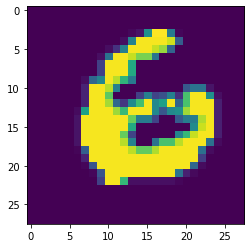

In [ ]:
check = test_images[500].reshape(28, 28, 1)

img = array_to_img(check)

plt.imshow(img)

In [ ]:
np.argmax(model.predict(check[np.newaxis, ...]), axis = -1)

array([6])

In [ ]:
len(test_predictions), len(test_images)